In [1]:
import os
import shutil
import sys
import yaml
import numpy as np
import pandas as pd
import random
from datetime import datetime

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, root_mean_squared_error


from dataset.dataset_test import MolTestDatasetWrapper

from dataset.get_config import get_config 
import argparse
from torch_geometric.utils import  scatter, softmax

from torch_geometric.data import Data

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
apex_support = False
try:
    sys.path.append('./apex')
    from apex import amp

    apex_support = True
except:
    print("Please install apex for mixed precision training from: https://github.com/NVIDIA/apex")
    apex_support = False


def _save_config_file(model_checkpoints_folder):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        shutil.copy('./config_finetune.yaml', os.path.join(model_checkpoints_folder, 'config_finetune.yaml'))

def get_roc_auc_score(y_true, y_pred, is_valid):
    roc_list = []
    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == -1) > 0:
            is_valid = y_true[:,i]**2 > 0
            roc_list.append(roc_auc_score((y_true[is_valid,i] + 1)/2, y_pred[is_valid,i]))

    if len(roc_list) < y_true.shape[1]:
        print("Some target is missing!")
        print("Missing ratio: %f" %(1 - float(len(roc_list))/y_true.shape[1]))

    return  sum(roc_list)/len(roc_list)




class Normalizer(object):
    """Normalize a Tensor and restore it later. """

    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']


Please install apex for mixed precision training from: https://github.com/NVIDIA/apex


In [3]:
class Args:
    batch_size = 32
    epochs = 200
    init_lr = 0.0005
    init_base_lr = 0.0001
    weight_decay = 1e-6
    
    gpu = 'cuda:1'
    model_type = 'gin'
    num_layer = 5
    emb_dim = 300
    feat_dim = 300
    dropout = 0.3
    pool = 'mean'
    seed = '42'

    task_name = 'sider'
    splitting = 'scaffold'
    random_masking = 1
    mask_rate = 0.2
    mask_edge = 0 
    alpha = 0.1
    reduceTrain = 1

args = Args()

In [4]:
config = yaml.load(open("config_finetune.yaml", "r"), Loader=yaml.FullLoader)

In [5]:
seed = args.seed

In [6]:
config['batch_size'] = args.batch_size
config['epochs'] = args.epochs
config['init_lr'] = args.init_lr
config['init_base_lr'] = args.init_base_lr
# config['weight_decay'] = args.weight_decay
config['gpu'] = args.gpu   
config['model']['num_layer'] = args.num_layer
config['model']['emb_dim'] = args.emb_dim
config['model']['feat_dim'] = args.feat_dim
config['model']['drop_ratio'] = args.dropout
config['model']['pool'] = args.pool

config['task_name'] = args.task_name
config['dataset']['seed'] = seed

config['dataset']['splitting'] = args.splitting

In [7]:
seed =  int(args.seed)

In [8]:
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

config['task_name'] = config['task_name'].lower()

In [9]:
config = get_config(config)

### main으로 넘어옴

In [10]:
dataset = MolTestDatasetWrapper(config['batch_size'],
                                **config['dataset'],
                                random_masking=args.random_masking,
                                mask_rate=args.mask_rate,
                                mask_edge=args.mask_edge)

## step 과 test 옮기기

In [11]:
    def _get_device():
        if torch.cuda.is_available() and config['gpu'] != 'cpu':
            device = config['gpu']
            torch.cuda.set_device(device)
            args.deviceName = "cuda" + str(device[-1])

        else:
            device = 'cpu'
            args.deviceName = 'cpu'

        print("Running on:", device)

        return device

In [12]:
device = _get_device()

Running on: cuda:1


In [14]:
savefilename = 'finetunesider_tsne'

In [15]:
layout = {
    "recon": {
        "loss_end": ["Multiline", ["loss_end/train", "loss_end/validation"]],
        "loss_recon_node" : ["Multiline", ["loss_recon_node/train"]],
        "loss_recon_edge" : ["Multiline", ["loss_recon_edge/train"]],
        "loss_total" : ["Multiline", ["loss_total/train", "loss_total/validation"]],
        "accuracy": ["Multiline", [ "accuracy/validation"]],
    },
}

In [16]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
dir_name =  savefilename + config['task_name'] + '_' + str(args.num_layer) + '_' \
+ str(args.emb_dim) + '_' + str(args.feat_dim)  + '_' + str(args.dropout) + '_' \
+ str(args.splitting) + '_' + str(args.deviceName) + '_' + str(args.seed) + '_' + str(current_time)

log_dir = os.path.join('finetune', dir_name)
writer = SummaryWriter(log_dir=log_dir)
writer.add_custom_scalars(layout)

dataset = dataset
if config['dataset']['task'] == 'classification':
    criterion =  nn.BCEWithLogitsLoss(reduction = "none")
elif config['dataset']['task'] == 'regression':
    if config["task_name"] in ['qm7', 'qm8', 'qm9']:
        criterion = nn.L1Loss()
    else:
        criterion = nn.MSELoss()
criterion_recon = nn.CrossEntropyLoss()

In [17]:
config['model']['mask_rate'] = args.mask_rate

In [18]:
train_loader, valid_loader, test_loader = dataset.get_data_loaders()

1426
About to generate scaffolds
Generating scaffold 0/1426
Generating scaffold 1000/1426
About to sort in scaffold sets


In [94]:
file_base = f"./data_save/{config['task_name']}/{config['task_name']}_{args.splitting}_{args.seed}.pkl"
file_base

'./data_save/bbbp/bbbp_scaffold_42.pkl'

In [95]:
dir_name = f"./data_save/{config['task_name']}"

In [96]:
dir_name

'./data_save/bbbp'

In [21]:
file_name_train = dir_name + f"/{config['task_name']}_{args.splitting}_{args.seed}_train.pkl" 
file_name_valid = dir_name + f"/{config['task_name']}_{args.splitting}_{args.seed}_valid.pkl" 
file_name_test = dir_name + f"/{config['task_name']}_{args.splitting}_{args.seed}_test.pkl"

In [262]:
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [263]:
import pickle
with open(file_name_train, 'wb') as f:
    pickle.dump(train_loader.dataset, f)

with open(file_name_valid, 'wb') as f:
    pickle.dump(valid_loader.dataset, f)
    
with open(file_name_test, 'wb') as f:
    pickle.dump(test_loader.dataset, f)

In [22]:
import pickle

with open(file_name_train, 'rb') as f:
    train_dataset = pickle.load(f)

with open(file_name_valid, 'rb') as f:
    valid_dataset = pickle.load(f)

with open(file_name_test, 'rb') as f:
    test_dataset = pickle.load(f)

In [24]:
from torch_geometric.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers = config['dataset']['num_workers'])
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers = config['dataset']['num_workers'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers = config['dataset']['num_workers'])

In [19]:
selected_datasets = ['FreeSolv',
                        'ESOL',
                         'qm7',
                        'Lipo',
                        'BACE',
                        'BBBP',
                        'ClinTox'
                        'sider',
                        'tox21']

In [19]:
selected_datasets_lower = [x.lower() for x in selected_datasets]

NameError: name 'selected_datasets' is not defined

In [ ]:
normalizer = None
if config["task_name"] in ['qm7', 'qm9']:
    labels = []
    for d  in train_loader:
        labels.append(d.y)
    labels = torch.cat(labels)
    normalizer = Normalizer(labels)
    print(normalizer.mean, normalizer.std, labels.shape)

In [22]:
import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool

num_atom_type = 120 # including the extra mask tokens
num_chirality_tag = 3

num_bond_type = 6 # including aromatic and self-loop edge
num_bond_direction = 4

from util import topk, bottomk


class GINEConv(MessagePassing):
    def __init__(self, emb_dim):
        super(GINEConv, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 2*emb_dim), 
            nn.ReLU(), 
            nn.Linear(2*emb_dim, emb_dim)
        )
        self.edge_embedding1 = nn.Embedding(num_bond_type, emb_dim)
        self.edge_embedding2 = nn.Embedding(num_bond_direction, emb_dim)

        nn.init.xavier_uniform_(self.edge_embedding1.weight.data)
        nn.init.xavier_uniform_(self.edge_embedding2.weight.data)
        # nn.init.xavier_uniform_(self.edge_embedding3.weight.data)


    def forward(self, x, edge_index, edge_attr):
        # add self loops in the edge space
        edge_index = add_self_loops(edge_index, num_nodes=x.size(0))[0]

        # add features corresponding to self-loop edges.
        self_loop_attr = torch.zeros(x.size(0), 2)
        self_loop_attr[:,0] = 4 # bond type for self-loop edge
        self_loop_attr = self_loop_attr.to(edge_attr.device).to(edge_attr.dtype)

        edge_attr = torch.cat((edge_attr, self_loop_attr), dim=0)
        

        edge_embeddings = self.edge_embedding1(edge_attr[:,0]) + \
            self.edge_embedding2(edge_attr[:,1])  

        return self.propagate(edge_index, x=x, edge_attr=edge_embeddings)

    def message(self, x_j, edge_attr):
        return x_j + edge_attr

    def update(self, aggr_out):
        return self.mlp(aggr_out)



class GINetRecon_rich_top(nn.Module):
    """
    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        drop_ratio (float): dropout rate
        gnn_type: gin, gcn, graphsage, gat
    Output:
        node representations
    """
    def __init__(self, 
        task='classification', num_layer=5, emb_dim=300, feat_dim=512, 
        drop_ratio=0, pool='mean', pred_n_layer=2, pred_act='softplus', num_task = 1, mask_rate = None,
    ):
        super(GINetRecon_rich_top, self).__init__()
        self.num_layer = num_layer
        self.emb_dim = emb_dim
        self.feat_dim = feat_dim
        self.drop_ratio = drop_ratio
        self.task = task
        self.num_task = num_task
        self.mask_rate = mask_rate

        self.x_embedding1 = nn.Embedding(num_atom_type, emb_dim)
        self.x_embedding2 = nn.Embedding(num_chirality_tag, emb_dim)

        nn.init.xavier_uniform_(self.x_embedding1.weight.data)
        nn.init.xavier_uniform_(self.x_embedding2.weight.data)



        # List of MLPs
        self.gnns = nn.ModuleList()
        for layer in range(num_layer):
            self.gnns.append(GINEConv(emb_dim))

        # List of batchnorms
        self.batch_norms = nn.ModuleList()
        for layer in range(num_layer):
            self.batch_norms.append(nn.BatchNorm1d(emb_dim))

        if pool == 'mean':
            self.pool = global_mean_pool
        elif pool == 'max':
            self.pool = global_max_pool
        elif pool == 'add':
            self.pool = global_add_pool
        self.feat_lin = nn.Linear(self.emb_dim, self.feat_dim)


        self.pred_n_layer = max(1, pred_n_layer)

        if pred_act == 'relu':
            pred_head = [
                nn.Linear(self.feat_dim, self.feat_dim//2), 
                nn.ReLU(inplace=True)
            ]
            for _ in range(self.pred_n_layer - 1):
                pred_head.extend([
                    nn.Linear(self.feat_dim//2, self.feat_dim//2), 
                    nn.ReLU(inplace=True),
                ])
            pred_head.append(nn.Linear(self.feat_dim//2, num_task))

        elif pred_act == 'softplus':
            pred_head = [
                nn.Linear(self.feat_dim, self.feat_dim//2), 
                nn.Softplus()
            ]
            for _ in range(self.pred_n_layer - 1):
                pred_head.extend([
                    nn.Linear(self.feat_dim//2, self.feat_dim//2), 
                    nn.Softplus()
                ])
        else:
            raise ValueError('Undefined activation function')
        
        self.dense_score = nn.Linear(self.feat_dim, 1)  # for node score

        self.pred_head = nn.Sequential(*pred_head)

        self.pred_head_last = nn.Linear(self.feat_dim//2, num_task)
                        
        # self.pred_head = nn.Sequential(*pred_head)

    def forward(self, data, mask_node = None, mask_rate = None, rank_method = 'topk'):

        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr

        if mask_node is not None:
            feature_0_mask = self.x_embedding1(x[:,0].long())
            feature_1_mask = self.x_embedding2(x[:,1].long())
            
            feature_0_mask[mask_node] = torch.zeros(self.emb_dim).to(feature_0_mask.device)
            feature_1_mask[mask_node] = torch.zeros(self.emb_dim).to(feature_1_mask.device)

            h = feature_0_mask + feature_1_mask

        else: 
            
            h = self.x_embedding1(x[:,0]) + self.x_embedding2(x[:,1])


        for layer in range(self.num_layer):
            h = self.gnns[layer](h, edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            if layer == self.num_layer - 1:
                h = F.dropout(h, self.drop_ratio, training=self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training=self.training)

        h_node = h

        h  = self.pool(h, data.batch)


        if  mask_rate is not None:
            score = self.dense_score(h_node).squeeze()

            mask_rate = float(mask_rate)

            if rank_method == 'topk':
                node = topk(score, mask_rate, batch = data.batch) 
            elif rank_method == 'bottomk':
                node = bottomk(score, mask_rate, batch = data.batch)


            h = self.pred_head(h)

            h_tsne = h

            h = self.pred_head_last(h)
            
            return  h_node, h_tsne, h,  node
        
        else:
  
            h = self.pred_head(h)

            h_tsne = h 

            h = self.pred_head_last(h)


            return  h_node, h_tsne, h

In [23]:
model = GINetRecon_rich_top(config['dataset']['task'], **config["model"]).to(device)

In [24]:
layer_list = []
for name, param in model.named_parameters():
    if 'pred_head' in name:
        print(name, param.requires_grad)
        layer_list.append(name)

params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in layer_list, model.named_parameters()))))
base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in layer_list, model.named_parameters()))))

linear_pred_atoms = torch.nn.Linear(args.emb_dim, 119).to(device)
linear_pred_bonds = torch.nn.Linear(args.emb_dim, 4).to(device)


optimizer_model = torch.optim.Adam(
    [{'params': base_params, 'lr': config['init_base_lr']}, {'params': params}],
    config['init_lr'], weight_decay=eval(config['weight_decay'])
)

optimizer_linear_pred_atoms = torch.optim.Adam(linear_pred_atoms.parameters(), lr=args.init_base_lr, weight_decay=eval(config['weight_decay']))
optimizer_linear_pred_bonds = torch.optim.Adam(linear_pred_bonds.parameters(), lr=args.init_base_lr, weight_decay=eval(config['weight_decay']))

model_list = [model, linear_pred_atoms, linear_pred_bonds]
optimizer_list = [optimizer_model, optimizer_linear_pred_atoms, optimizer_linear_pred_bonds]

if apex_support and config['fp16_precision']:
    model, optimizer = amp.initialize(
        model, optimizer, opt_level='O2', keep_batchnorm_fp32=True
    )

model_checkpoints_folder = os.path.join(writer.log_dir, 'checkpoints')

# save config file
_save_config_file(model_checkpoints_folder)

pred_head.0.weight True
pred_head.0.bias True
pred_head.2.weight True
pred_head.2.bias True
pred_head_last.weight True
pred_head_last.bias True


In [25]:
    def _step( model_list, data, n_iter):
        model, linear_pred_atoms, linear_pred_bonds = model_list


        num_atom_type = 119
        num_edge_type = 4

        # get the prediction
        node_rep, _,    pred, node_top = model(data, mask_rate = args.mask_rate )  # [N,C]

 
        mask_node_labels_list = []
        for atom_idx in node_top:
            mask_node_labels_list.append(data.x[atom_idx].view(1, -1))

        mask_node_label = torch.cat(mask_node_labels_list, dim=0)
        masked_atom_indices = torch.tensor(node_top)

        masked_x = data.x.clone()

        for atom_idx in masked_atom_indices:
            masked_x[atom_idx] = torch.tensor([num_atom_type, 0]).to(device)


        if args.mask_edge:
            # edge_index 찾기
            connected_edge_indices = []
            for bond_idx, (u, v) in enumerate(data.edge_index.cpu().numpy().T):
                for atom_idx in masked_atom_indices:
                    if atom_idx in set((u, v)) and \
                        bond_idx not in connected_edge_indices:
                        connected_edge_indices.append(bond_idx)

            if len(connected_edge_indices) > 0:
                # create mask edge labels by copying bond features of the bonds connected to
                # the mask atoms
                mask_edge_labels_list = []
                for bond_idx in connected_edge_indices[::2]: # because the
                    # edge ordering is such that two directions of a single
                    # edge occur in pairs, so to get the unique undirected
                    
                    # edge indices, we take every 2nd edge index from list
                    mask_edge_labels_list.append(
                        data.edge_attr[bond_idx].view(1, -1))

                mask_edge_label = torch.cat(mask_edge_labels_list, dim=0)
                # modify the original bond features of the bonds connected to the mask atoms

                connected_edge_indices = torch.tensor(
                    connected_edge_indices[::2])
            else:
                mask_edge_label = torch.empty((0, 2)).to(torch.int64)
                connected_edge_indices = torch.tensor(
                    connected_edge_indices).to(torch.int64)

            # 데이터 마스킹 하고 예측하기   
            masked_edge_attr = data.edge_attr.clone()

            for edge_idx in connected_edge_indices:
                masked_edge_attr[edge_idx] = torch.tensor([num_edge_type, 0]).to(device)

            masked_edge_index = data.edge_index[:, data.connected_edge_indices]

            masked_data = Data(x = masked_x ,edge_index = data.edge_index, edge_attr = masked_edge_attr) 

            node_rep_masked, output2_masked = model(data)

            # edge_rep      
            edge_rep = node_rep_masked[masked_edge_index[0]] + node_rep_masked[masked_edge_index[1]]
            pred_edge = linear_pred_bonds(edge_rep)
           
            loss_recon_edge = criterion_recon(pred_edge.double(),  mask_edge_label[:,0])


            pred_node = linear_pred_atoms(node_rep_masked[masked_atom_indices])
            loss_recon_node = criterion_recon(pred_node.float(), data.mask_node_label[:,0])
        
        else: 
            masked_data = Data(x =  data.x ,edge_index = data.edge_index, edge_attr = data.edge_attr, batch = data.batch) 

            node_repre2, _,  output2_masked= model(masked_data, mask_node = masked_atom_indices, mask_rate = None)
            
            pred_node = linear_pred_atoms(node_repre2[masked_atom_indices])
            loss_recon_node = criterion_recon(pred_node.double(), mask_node_label[:,0].long())

        if config['dataset']['task'] == 'classification':

            is_valid = data.y**2 > 0
            
            loss_mat = criterion(pred, (data.y+1)/2)
            loss_mat = torch.where(is_valid, loss_mat, torch.zeros(loss_mat.shape).to(loss_mat.device).to(loss_mat.dtype))


            loss = torch.sum(loss_mat) / torch.sum(is_valid)



        elif config['dataset']['task'] == 'regression':
            if normalizer:
                loss = criterion(pred, normalizer.norm(data.y))
            else:
                loss = criterion(pred, data.y)

        
        if args.mask_edge:
            total_loss = loss + args.alpha * (loss_recon_node + loss_recon_edge)
            return pred, total_loss, loss, loss_recon_node, loss_recon_edge
        else:
            total_loss = loss + args.alpha * loss_recon_node
            return pred, total_loss, loss, loss_recon_node, 0

In [26]:

def _step_test(model, data, n_iter):
    # get the prediction
    __, pred_tsne, pred = model(data)  # [N,C]

    if config['dataset']['task'] == 'classification':

        is_valid = data.y**2 > 0

        loss_mat = criterion(pred, (data.y+1)/2)
        loss_mat = torch.where(is_valid, loss_mat, torch.zeros(loss_mat.shape).to(loss_mat.device).to(loss_mat.dtype))


        loss = torch.sum(loss_mat) / torch.sum(is_valid)

    elif config['dataset']['task'] == 'regression':
        if normalizer:
            loss = criterion(pred, normalizer.norm(data.y))
        else:
            loss = criterion(pred, data.y)
    return loss


def _validate( model_list, valid_loader):
    model, linear_pred_atoms, linear_pred_bonds = model_list

    predictions = []
    labels = []
    with torch.no_grad():
        model.eval()
        linear_pred_atoms.eval()
        linear_pred_bonds.eval()



        valid_loss = 0.0
        num_data = 0
        for bn, data in enumerate(valid_loader):
            data = data.to(device)

            __, pred_tsn, pred  = model(data)
            loss = _step_test(model, data, bn)

            valid_loss += loss.item() * data.y.size(0)
            num_data += data.y.size(0)

            if normalizer:
                pred = normalizer.denorm(pred)

            if config['dataset']['task'] == 'classification':
                
                labels.append(data.y.view(pred.shape))
                predictions.append(pred)

            else:
                if device == 'cpu':
                    predictions.extend(pred.detach().numpy())
                    labels.extend(data.y.flatten().numpy())
                else:
                    predictions.extend(pred.cpu().detach().numpy())
                    labels.extend(data.y.cpu().flatten().numpy())

        valid_loss /= num_data
    
    model.train()
    linear_pred_atoms.train()
    linear_pred_bonds.train()


    if config['dataset']['task'] == 'regression':
        predictions = np.array(predictions)
        labels = np.array(labels)
        if config['task_name'] in ['qm7', 'qm8', 'qm9']:
            mae = mean_absolute_error(labels, predictions)
            print('Validation loss:', valid_loss, 'MAE:', mae)
            return valid_loss, mae
        else:
            rmse = root_mean_squared_error(labels, predictions, )
            print('Validation loss:', valid_loss, 'RMSE:', rmse)
            return valid_loss, rmse

    elif config['dataset']['task'] == 'classification':
        
        labels = torch.cat(labels, dim=0).cpu().numpy()
        predictions = torch.cat(predictions, dim=0).cpu().detach().numpy()

        is_valid = labels**2 > 0
        roc_auc = get_roc_auc_score(labels, predictions, is_valid)
        print('Validation loss:', valid_loss, 'ROC AUC:', roc_auc)
        return valid_loss, roc_auc


In [40]:
import numpy as np
n_iter = 0
valid_n_iter = 0
best_valid_loss = np.inf
best_valid_rgr = np.inf
best_valid_cls = 0

for epoch_counter in range(config['epochs']):
# for epoch_counter in range(2):
    
    for bn, data in enumerate(train_loader):
        predictions = []
        labels = []

        optimizer_model.zero_grad()
        optimizer_linear_pred_atoms.zero_grad()
        if args.mask_edge:
            optimizer_linear_pred_bonds.zero_grad()

        data = data.to(device)
        pred, total_loss, loss_end, loss_recon, loss_recon_edge = _step(model_list, data, n_iter)

        if n_iter % config['log_every_n_steps'] == 0:
            # writer.add_scalar('loss_total/train', total_loss, global_step=n_iter)
            writer.add_scalar('loss_total/train_loss_total', total_loss, epoch_counter)
            writer.add_scalar('loss_end/train_loss_end', loss_end, epoch_counter)
            writer.add_scalar('loss_recon_node/train_loss_recon_node', loss_recon, epoch_counter)
            writer.add_scalar('loss_recon_edge/train_loss_recon_edge', loss_recon_edge, epoch_counter)
        

            print(epoch_counter, bn, total_loss.item())

        if apex_support and config['fp16_precision']:
            with amp.scale_loss(total_loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            total_loss.backward()

        optimizer_model.step()
        optimizer_linear_pred_atoms.step()
        if args.mask_edge:
            optimizer_linear_pred_bonds.step()

        n_iter += 1


    # validate the model if requested
    if epoch_counter % config['eval_every_n_epochs'] == 0:
        if config['dataset']['task'] == 'classification': 


            valid_loss, valid_cls = _validate(model_list, valid_loader)
            if valid_cls > best_valid_cls:
                # save the model weights
                best_valid_cls = valid_cls
                torch.save(model.state_dict(), os.path.join(model_checkpoints_folder, 'model.pth'))

            writer.add_scalar('accuracy/validation', valid_cls, epoch_counter)
        elif config['dataset']['task'] == 'regression':

     
            valid_loss, valid_rgr = _validate(model_list, valid_loader)
            if valid_rgr < best_valid_rgr:
                # save the model weights
                best_valid_rgr = valid_rgr
                torch.save(model.state_dict(), os.path.join(model_checkpoints_folder, 'model.pth'))
            writer.add_scalar('accuracy/validation', valid_rgr, epoch_counter)

        writer.add_scalar('loss_end/validation_loss_end', valid_loss, epoch_counter)
        writer.add_scalar('loss_total/validation_loss_total', valid_loss, epoch_counter)

        valid_n_iter += 1

0 0 0.6292968837047691
0 50 0.4379707789612678
Validation loss: 0.541459393267538 ROC AUC: 0.9082880434782609
1 49 0.22586416791371655
Validation loss: 0.7017207116472954 ROC AUC: 0.8951863354037267
2 48 0.1981839119266072
Validation loss: 0.8379131520495695 ROC AUC: 0.8962538819875776
3 47 0.24012148336024836
Validation loss: 0.7733414383495555 ROC AUC: 0.8866459627329193
4 46 0.41875115755375303
Validation loss: 0.535764943150913 ROC AUC: 0.921875
5 45 0.12431586933173824
Validation loss: 0.8986247427323285 ROC AUC: 0.9006211180124224
6 44 0.14115060055084835
Validation loss: 0.7102252046267191 ROC AUC: 0.9050854037267081
7 43 0.35384791264084275
Validation loss: 0.564972019663044 ROC AUC: 0.907123447204969
8 42 0.23125298629813354
Validation loss: 0.6446790613380133 ROC AUC: 0.907026397515528
9 41 0.14025691706779597
Validation loss: 0.7917895550821342 ROC AUC: 0.8972243788819875
10 40 0.4840630548886052
Validation loss: 0.4055290607845082 ROC AUC: 0.9250776397515528
11 39 0.1510820

In [41]:
    model_path = os.path.join(writer.log_dir, 'checkpoints', 'model.pth')
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    print("Loaded trained model with success.")

    num_atom_type = 119
    num_edge_type = 4

    predictions_node = []
    labels_node = []
    predictions_edge = []
    labels_edge = []


Loaded trained model with success.


In [25]:
num_atom_type = 119
num_edge_type = 4

predictions_node = []
labels_node = []
predictions_edge = []
labels_edge = []

with torch.no_grad():
    model.eval()
    linear_pred_atoms.eval()
    linear_pred_bonds.eval()


## test data 전체에 대해서

In [26]:
import torch
from torch_geometric.data import Batch

# all_batches에 모든 배치를 리스트로 저장합니다.
all_batches = []

# train_loader로부터 배치를 가져와 리스트에 추가합니다.
for batch in test_loader:
    all_batches.append(batch)

# 모든 배치를 하나로 합칩니다.
merged_batch = Batch.from_data_list(all_batches)

In [27]:
merged_batch.to(device)

DataBatch(x=[15139, 2], edge_index=[2, 31142], edge_attr=[31142, 2], y=[143, 27], batch=[15139])

In [29]:
merged_batch.y

tensor([[ 1,  1, -1,  ..., -1,  1,  1],
        [ 1,  1, -1,  ..., -1,  1, -1],
        [ 1,  1, -1,  ...,  1,  1,  1],
        ...,
        [-1,  1, -1,  ...,  1,  1,  1],
        [ 1, -1, -1,  ..., -1, -1, -1],
        [ 1,  1, -1,  ...,  1,  1,  1]], device='cuda:1')

In [42]:
__, pred_tsne,   pred = model(merged_batch)

In [43]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pred_tsne_np = pred_tsne.detach().cpu().numpy()
target_values = merged_batch.y.detach().cpu().numpy()

pred_tsne_np = TSNE(n_components = 2).fit_transform(pred_tsne_np)

In [45]:
pred_tsne_np.shape

(143, 2)

In [38]:
num_classes = len(config['dataset']['target'])
num_classes

27

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def assign_colors(num_classes):
    """
    클래스 수에 따라 자동으로 색상을 할당하는 함수
    """
    colors = cm.rainbow(np.linspace(0, 1, num_classes))
    return colors

# 클래스 수에 따라 색상 할당
colors = assign_colors(num_classes)

plt.figure(figsize=(10, 10))

# 각 클래스에 대해 scatter plot 그리기
for class_label in range(num_classes):
    class_indices = target_values_1d == class_label
    plt.scatter(pred_tsne_np[class_indices, 0], pred_tsne_np[class_indices, 1], c=colors[class_label], label=f'Class {class_label}', alpha=0.7)

plt.title('Latent Space with Continuous Values', fontsize=15)
plt.xlabel('Z1', fontsize=15)
plt.ylabel('Z2', fontsize=15)
plt.legend()
plt.savefig(full_file_name_tsne)
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 143 but corresponding boolean dimension is 3861

<Figure size 1000x1000 with 0 Axes>

In [41]:
pred_tsne_np.shape

(143, 2)

In [ ]:
if config['dataset']['task'] == 'classification':

        # Assuming target_values is a 2D array, convert it to 1D
    target_values_1d = target_values.flatten()
    
    class1_indices = target_values_1d == 1
    class2_indices = target_values_1d == -1

    plt.figure(figsize=(10, 10))
    plt.scatter(pred_tsne_np[class1_indices, 0], pred_tsne_np[class1_indices, 1], c='blue', label='Class 1', alpha=0.7)
    # Plot class -1
    plt.scatter(pred_tsne_np[class2_indices, 0], pred_tsne_np[class2_indices, 1], c='red', label='Class -1', alpha=0.7)

    plt.colorbar(scatter, label='Target Value')
    plt.title('Latent Space with Continuous Values', fontsize=15)
    plt.xlabel('Z1', fontsize=15)
    plt.ylabel('Z2', fontsize=15)
    plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 143 but corresponding boolean dimension is 3861

<Figure size 1000x1000 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
      # assuming data.y is a tensor, convert it to numpy

target_values = merged_batch.y.detach().cpu().numpy()

# if pred_tsne is a tensor, convert it to numpy as well
pred_tsne_np = pred_tsne.detach().cpu().numpy()

if config['dataset']['task'] == 'regression':
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pred_tsne_np[:, 0], pred_tsne_np[:, 1], c=target_values, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Target Value')
    plt.title('Latent Space with Continuous Values', fontsize=15)
    plt.xlabel('Z1', fontsize=15)
    plt.ylabel('Z2', fontsize=15)
    plt.show()
    
elif config['dataset']['task'] == 'classification':

    # Assuming target_values is a 2D array, convert it to 1D
    target_values_1d = target_values.flatten()
    
    class1_indices = target_values_1d == 1
    class2_indices = target_values_1d == -1
    
    plt.figure(figsize=(10, 10))
    # Plot class 1
    plt.scatter(pred_tsne_np[class1_indices, 0], pred_tsne_np[class1_indices, 1], c='blue', label='Class 1', alpha=0.7)
    # Plot class -1
    plt.scatter(pred_tsne_np[class2_indices, 0], pred_tsne_np[class2_indices, 1], c='red', label='Class -1', alpha=0.7)

    plt.legend()
    plt.xlabel('Z1')
    plt.ylabel('Z2')
    plt.title('Latent Space')
    plt.show()

In [76]:
import matplotlib.pyplot as plt
      # assuming data.y is a tensor, convert it to numpy

target_values = merged_batch.y.detach().cpu().numpy()

# if pred_tsne is a tensor, convert it to numpy as well
pred_tsne_np = pred_tsne.detach().cpu().numpy()

if config['dataset']['task'] == 'regression':
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pred_tsne_np[:, 0], pred_tsne_np[:, 1], c=target_values, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Target Value')
    plt.title('Latent Space with Continuous Values', fontsize=15)
    plt.xlabel('Z1', fontsize=15)
    plt.ylabel('Z2', fontsize=15)
    plt.show()
    
elif config['dataset']['task'] == 'classification':

    # Assuming target_values is a 2D array, convert it to 1D
    target_values_1d = target_values.flatten()
    
    class1_indices = target_values_1d == 1
    class2_indices = target_values_1d == -1
    
    plt.figure(figsize=(10, 10))
    # Plot class 1
    plt.scatter(pred_tsne_np[class1_indices, 0], pred_tsne_np[class1_indices, 1], c='blue', label='Class 1', alpha=0.7)
    # Plot class -1
    plt.scatter(pred_tsne_np[class2_indices, 0], pred_tsne_np[class2_indices, 1], c='red', label='Class -1', alpha=0.7)

    plt.legend()
    plt.xlabel('Z1')
    plt.ylabel('Z2')
    plt.title('Latent Space')
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

## test data 하나씩1

torch.Size([32, 2])


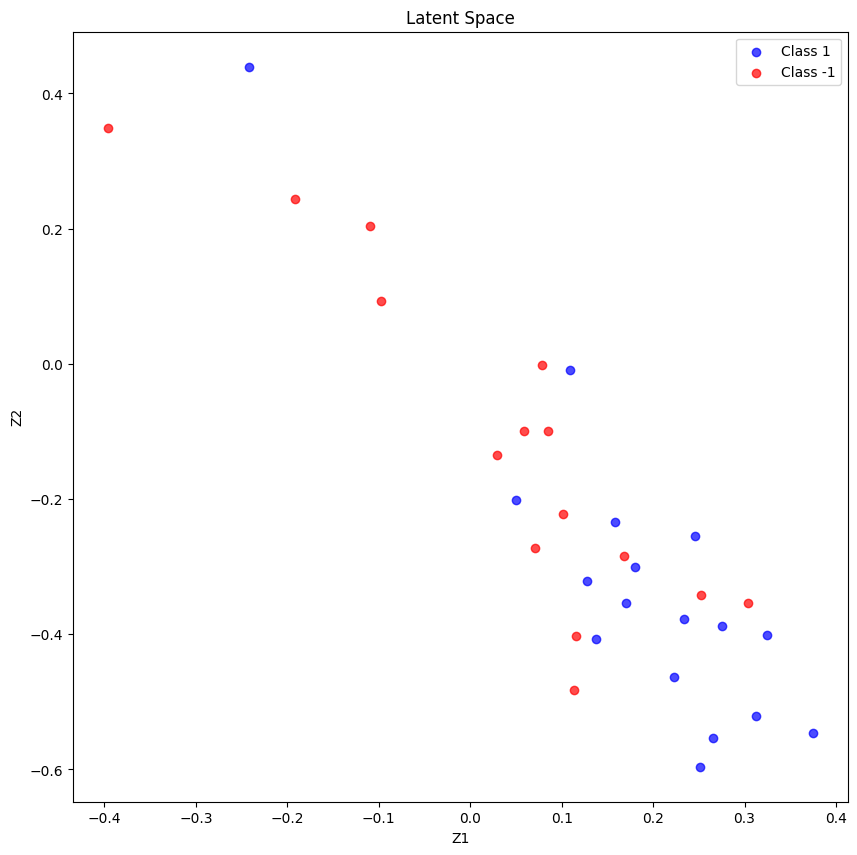

torch.Size([32, 2])


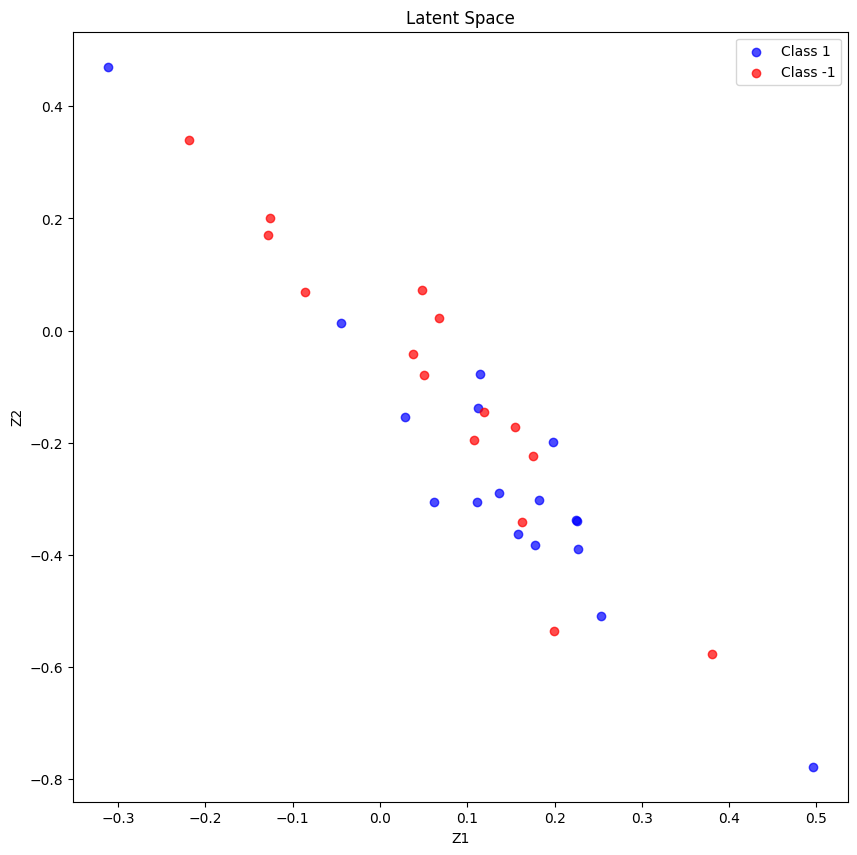

torch.Size([32, 2])


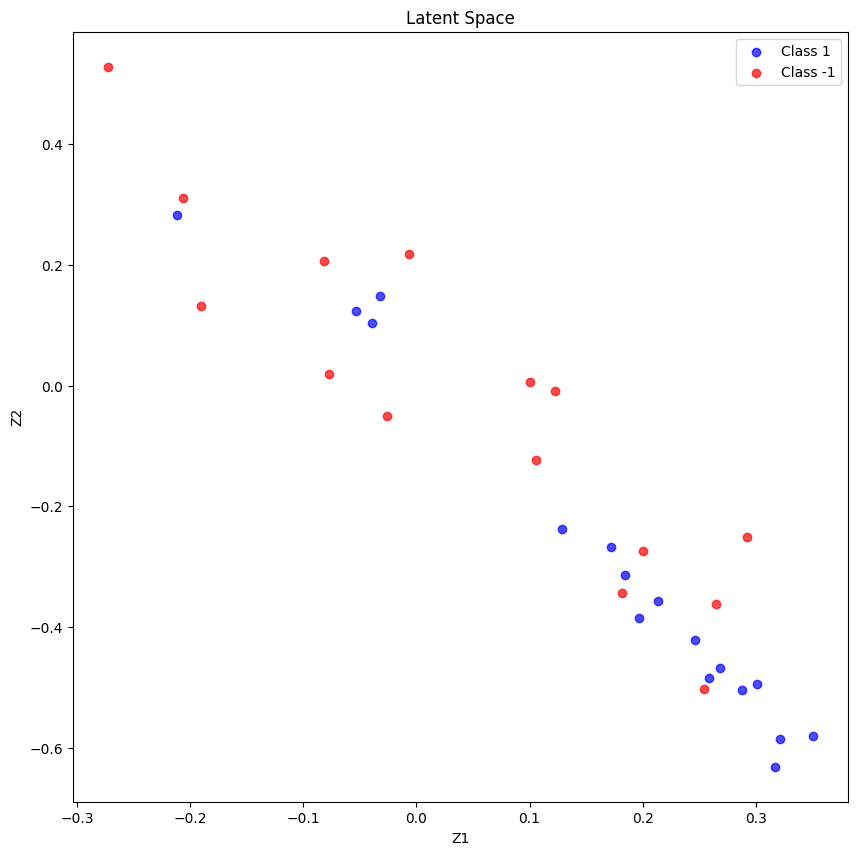

torch.Size([32, 2])


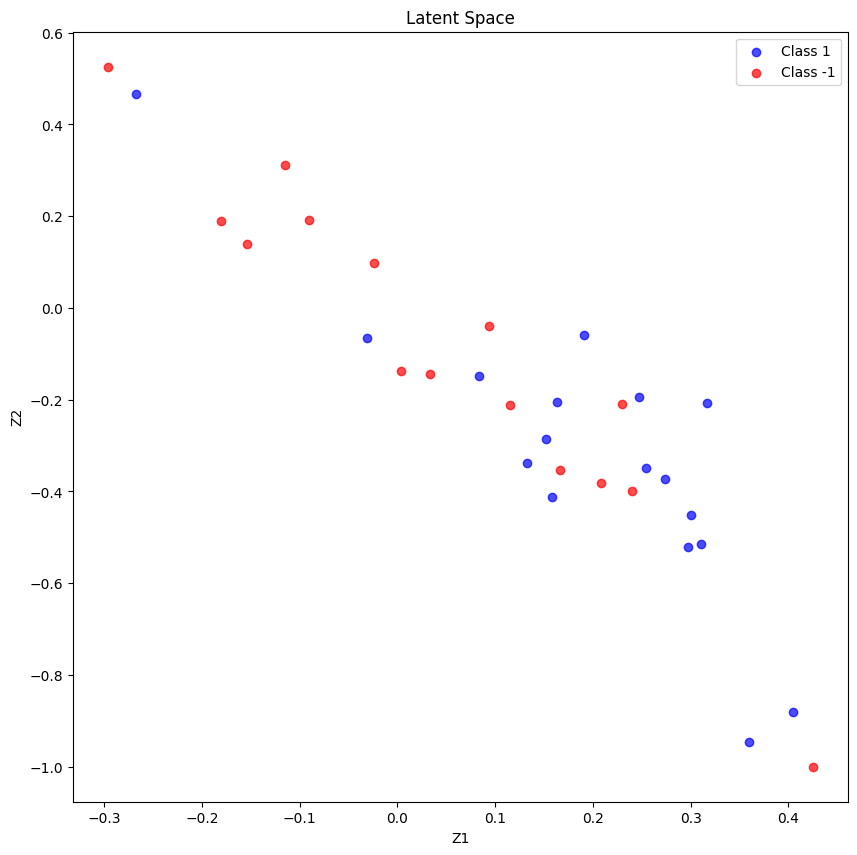

torch.Size([32, 2])


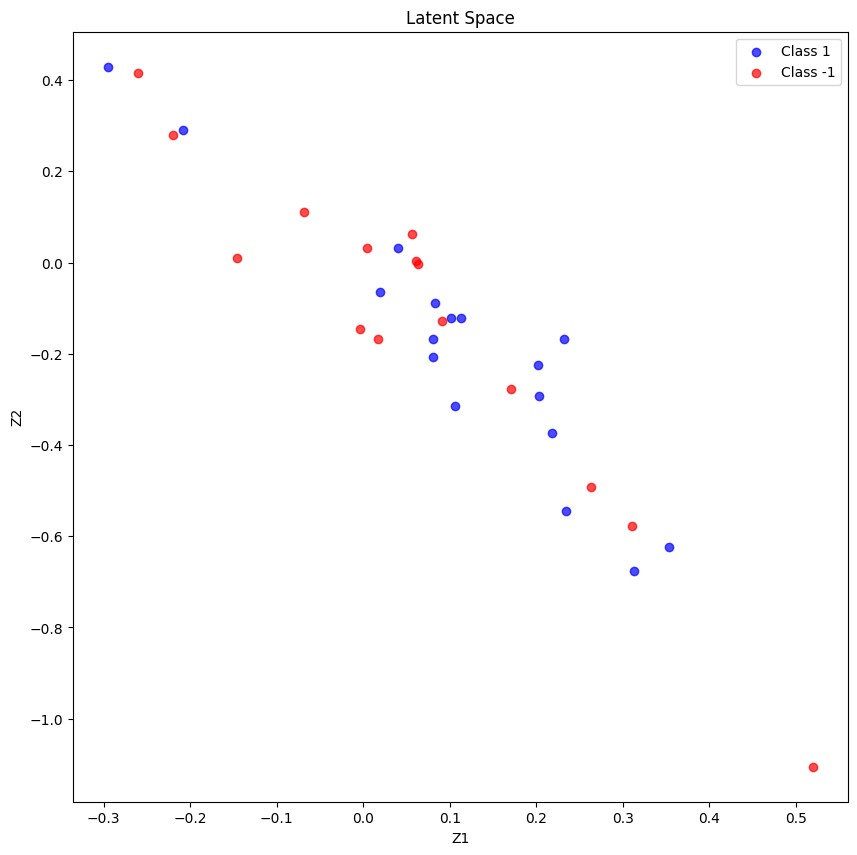

torch.Size([32, 2])


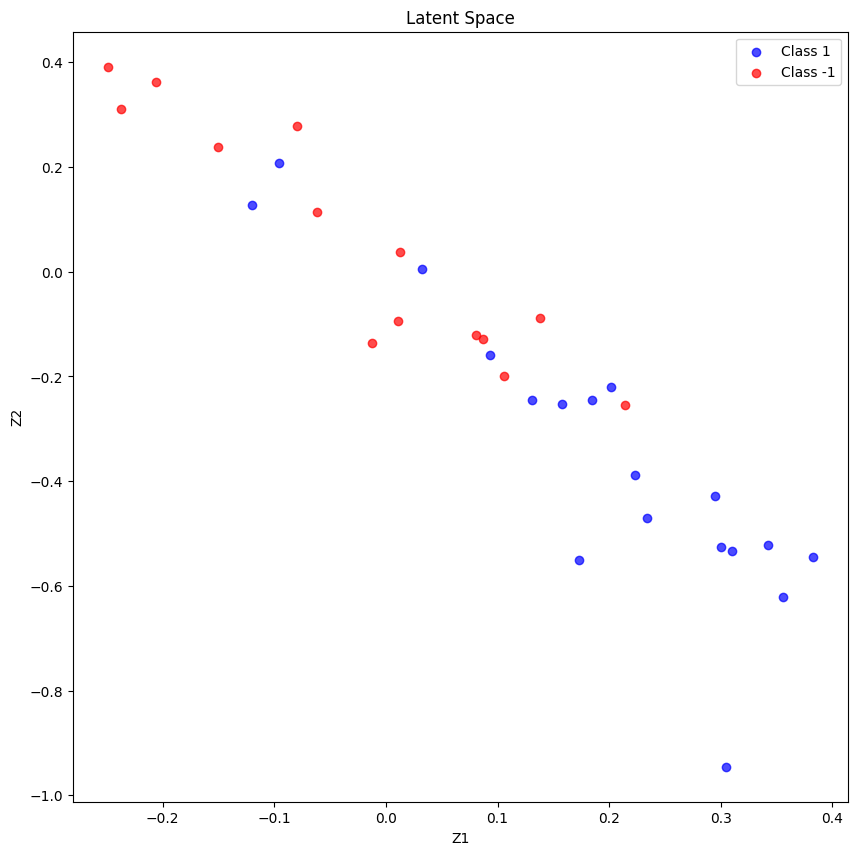

torch.Size([12, 2])


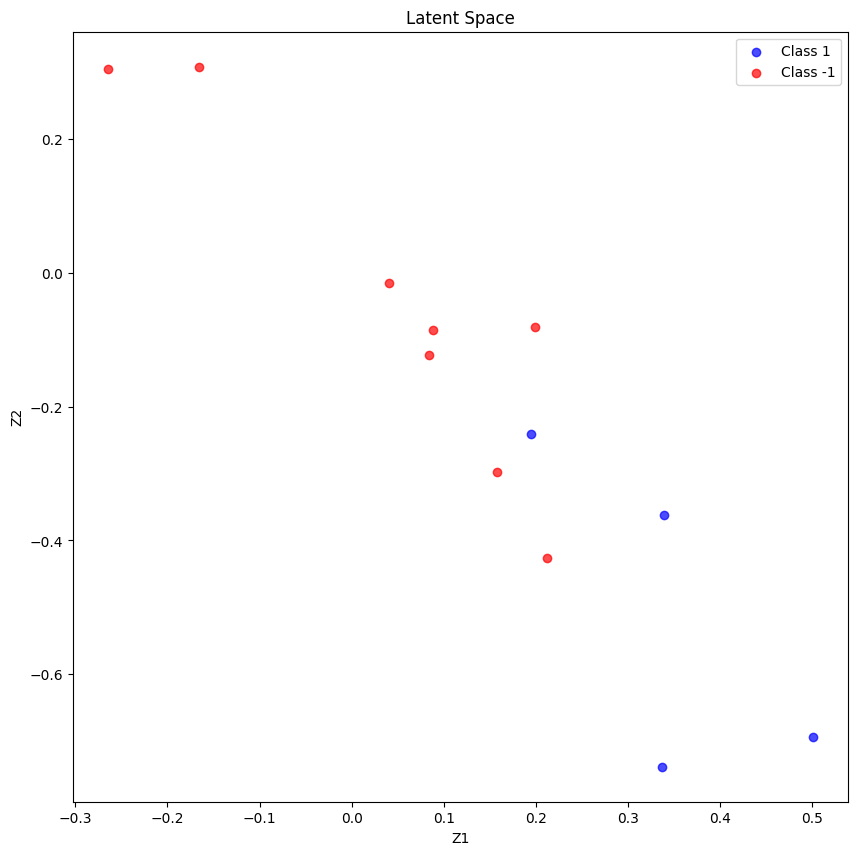

Test loss: 1.4646340889089249 Test ROC AUC: 0.7528663647750266


In [185]:
import matplotlib.pyplot as plt
# test steps
predictions = []
labels = []
with torch.no_grad():
    model.eval()
    linear_pred_atoms.eval()
    linear_pred_bonds.eval()
    
    test_loss = 0.0
    num_data = 0
    for bn, data in enumerate(test_loader):
        data = data.to(device)
    
        __, pred_tsne, pred = model(data)
        print(pred_tsne.shape)
    
        if config['dataset']['task'] == 'classification':
    
            is_valid = data.y**2 > 0
    
            loss_mat = criterion(pred, (data.y+1)/2)
            loss_mat = torch.where(is_valid, loss_mat, torch.zeros(loss_mat.shape).to(loss_mat.device).to(loss_mat.dtype))
    
    
            loss = torch.sum(loss_mat) / torch.sum(is_valid)
    
        elif config['dataset']['task'] == 'regression':
                if normalizer:
                    loss = criterion(pred, self.normalizer.norm(data.y))
                else:
                    loss = criterion(pred, data.y)
      
    
        test_loss += loss.item() * data.y.size(0)
        num_data += data.y.size(0)
    
        if normalizer:
            pred = self.normalizer.denorm(pred)
    
        if config['dataset']['task'] == 'classification':
    
            predictions.append(pred)
            labels.append(data.y.view(pred.shape))
    
        else:
            if device == 'cpu':
                predictions.extend(pred.detach().numpy())
                labels.extend(data.y.flatten().numpy())
            else:
                predictions.extend(pred.cpu().detach().numpy())
                labels.extend(data.y.cpu().flatten().numpy())


                # assuming data.y is a tensor, convert it to numpy
        target_values = data.y.cpu().numpy()
        
        # if pred_tsne is a tensor, convert it to numpy as well
        pred_tsne_np = pred_tsne.cpu().numpy()

        if config['dataset']['task'] == 'regression':
            plt.figure(figsize=(10, 10))
            scatter = plt.scatter(pred_tsne_np[:, 0], pred_tsne_np[:, 1], c=target_values, cmap='viridis', alpha=0.7)
            plt.colorbar(scatter, label='Target Value')
            plt.title('Latent Space with Continuous Values', fontsize=15)
            plt.xlabel('Z1', fontsize=15)
            plt.ylabel('Z2', fontsize=15)
            plt.show()
            
        elif config['dataset']['task'] == 'classification':

            # Assuming target_values is a 2D array, convert it to 1D
            target_values_1d = target_values.flatten()
            
            class1_indices = target_values_1d == 1
            class2_indices = target_values_1d == -1
            
            plt.figure(figsize=(10, 10))
            # Plot class 1
            plt.scatter(pred_tsne_np[class1_indices, 0], pred_tsne_np[class1_indices, 1], c='blue', label='Class 1', alpha=0.7)
            # Plot class -1
            plt.scatter(pred_tsne_np[class2_indices, 0], pred_tsne_np[class2_indices, 1], c='red', label='Class -1', alpha=0.7)

            plt.legend()
            plt.xlabel('Z1')
            plt.ylabel('Z2')
            plt.title('Latent Space')
            plt.show()
        
    test_loss /= num_data
    
model.train()
linear_pred_atoms.train()
linear_pred_bonds.train()
    
if config['dataset']['task'] == 'regression':
    predictions = np.array(predictions)
    labels = np.array(labels)
    if config['task_name'] in ['qm7', 'qm8', 'qm|9']:
        mae = mean_absolute_error(labels, predictions)
        print('Test loss:', test_loss, 'Test MAE:', mae)
    else:
        rmse = root_mean_squared_error(labels, predictions, )
        print('Test loss:', test_loss, 'Test RMSE:', rmse)
    
elif config['dataset']['task'] == 'classification': 
    
        labels = torch.cat(labels, dim=0).cpu().numpy()
        predictions = torch.cat(predictions, dim=0).cpu().numpy()
        
        is_valid = labels**2 > 0
        roc_auc = get_roc_auc_score(labels, predictions, is_valid)
    
        print('Test loss:', test_loss, 'Test ROC AUC:', roc_auc)


In [170]:
target_values

array([-1])

In [157]:
it = iter(test_loader)
test = next(it)

In [171]:
test.y[0]

tensor([1])

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit import RDLogger

ATOM_LIST = list(range(1,119))
CHIRALITY_LIST = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER
]
BOND_LIST = [BT.SINGLE, BT.DOUBLE, BT.TRIPLE, BT.AROMATIC]
BONDDIR_LIST = [
    Chem.rdchem.BondDir.NONE,
    Chem.rdchem.BondDir.ENDUPRIGHT,
    Chem.rdchem.BondDir.ENDDOWNRIGHT
]

In [91]:
mol = Chem.MolFromSmiles(smiles)

In [92]:
config['dataset']['task']

'classification'

In [93]:
labels = 1

In [94]:

from tqdm import tqdm as core_tqdm
from typing import List, Set, Tuple, Union, Dict
from collections import defaultdict

def onek_encoding_unk(value : int, choices: List[int]) -> List[int]:
    """
        Creates a one-hot encoding.

    :param value: The value for which the encoding should be one.
    :param choices: A list of possible values.
    :return: A one-hot encoding of the value in a list of length len(choices) + 1.
    If value is not in the list of choices, then the final element in the encoding is 1.

    """
    encoding = [0] * len(choices)
    if value in choices:
        encoding[choices.index(value)] = 1
    else:
        encoding[-1] = 1
    return encoding

# rich_feature로 사용할 feature
ATOM_FEATURES = {
    'atomic_num' : list(range(1, 119)),
    'degree' : [0,1,2,3,4,5],
    'formal_charge' : [0, -1, -2, 1, 2],
    'chiral_tag' : [0,1,2,3],
    'num_Hs' : [0,1,2,3,4],
    'hybridization': [

        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2
    ],
}

from descriptastorus.descriptors import rdDescriptors, rdNormalizedDescriptors


In [95]:
config['dataset']['task']

'classification'

In [96]:
mol = Chem.AddHs(mol)

N = mol.GetNumAtoms()
M = mol.GetNumBonds()

type_idx = []
chirality_idx = []
atomic_number = []
formal_charge = []
total_numHs = []
hybridzation = []
aromatic = []
mass = []

implicitValence_list = []
hydrogen_acceptor_match_list = []
hydrogen_donor_match_list = []
acidic_match_list = []
basic_match_list = []
ring_info_list = []

degree = []


hydrogen_donor = Chem.MolFromSmarts("[$([N;!H0;v3,v4&+1]),$([O,S;H1;+0]),n&H1&+0]")
hydrogen_acceptor = Chem.MolFromSmarts(
    "[$([O,S;H1;v2;!$(*-*=[O,N,P,S])]),$([O,S;H0;v2]),$([O,S;-]),$([N;v3;!$(N-*=[O,N,P,S])]),"
    "n&H0&+0,$([o,s;+0;!$([o,s]:n);!$([o,s]:c:n)])]")
acidic = Chem.MolFromSmarts("[$([C,S](=[O,S,P])-[O;H1,-1])]")
basic = Chem.MolFromSmarts(
    "[#7;+,$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);"
"!$([C,a](=O))]),$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))])]")


for atom in mol.GetAtoms():
    type_idx.append(ATOM_LIST.index(atom.GetAtomicNum()))
    chirality_idx.append(CHIRALITY_LIST.index(atom.GetChiralTag()))
    degree.append( onek_encoding_unk(atom.GetTotalDegree(), ATOM_FEATURES['degree']) )
    formal_charge.append( onek_encoding_unk(atom.GetFormalCharge(), ATOM_FEATURES['formal_charge']) )
    total_numHs.append( onek_encoding_unk(int(atom.GetTotalNumHs()), ATOM_FEATURES['num_Hs']) )
    hybridzation.append( onek_encoding_unk(int(atom.GetHybridization()), ATOM_FEATURES['hybridization']) )
    aromatic.append([1 if atom.GetIsAromatic() else 0])
    mass.append([atom.GetMass() * 0.01])

    atom_idx = atom.GetIdx()

    hydrogen_donor_match = sum(mol.GetSubstructMatches(hydrogen_donor), ())
    hydrogen_acceptor_match = sum(mol.GetSubstructMatches(hydrogen_acceptor), ())
    acidic_match = sum(mol.GetSubstructMatches(acidic), ())
    basic_match = sum(mol.GetSubstructMatches(basic), ())

    implicitValence_list.append(onek_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]))
    hydrogen_acceptor_match_list.append([atom_idx in hydrogen_acceptor_match])
    hydrogen_donor_match_list.append([atom_idx in hydrogen_donor_match])
    acidic_match_list.append([atom_idx in acidic_match])
    basic_match_list.append([atom_idx in basic_match])

    ring_info = mol.GetRingInfo()
    ring_info_list.append(                [ring_info.IsAtomInRingOfSize(atom_idx, 3),
            ring_info.IsAtomInRingOfSize(atom_idx, 4),
            ring_info.IsAtomInRingOfSize(atom_idx, 5),
            ring_info.IsAtomInRingOfSize(atom_idx, 6),
            ring_info.IsAtomInRingOfSize(atom_idx, 7),
            ring_info.IsAtomInRingOfSize(atom_idx, 8)])
                                   
                   
x1 = torch.tensor(type_idx, dtype=torch.long).view(-1, 1)
x2 = torch.tensor(chirality_idx, dtype=torch.long).view(-1, 1)
x3 = torch.tensor(degree, dtype=torch.long)
x4 = torch.tensor(formal_charge, dtype=torch.long)
x5 = torch.tensor(total_numHs, dtype=torch.long)
x6 = torch.tensor(hybridzation, dtype=torch.long)
x7 = torch.tensor(aromatic, dtype=torch.long)
x8 = torch.tensor(mass, dtype=torch.float)

x9 = torch.tensor(implicitValence_list, dtype=torch.long)
x10 = torch.tensor(hydrogen_acceptor_match_list, dtype=torch.long)
x11 = torch.tensor(hydrogen_donor_match_list, dtype=torch.long)
x12 = torch.tensor(acidic_match_list, dtype=torch.long)
x13 = torch.tensor(basic_match_list, dtype=torch.long)
x14 = torch.tensor(ring_info_list, dtype=torch.long)


x = torch.cat([x1, x2, x3, x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14], dim=1)

row, col, edge_feat = [], [], []
for bond in mol.GetBonds():
    start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    row += [start, end]
    col += [end, start]
    bt = bond.GetBondType()
    feat1 = [
        BOND_LIST.index(bond.GetBondType()),
        BONDDIR_LIST.index(bond.GetBondDir()),
        bond.GetIsConjugated() if bt is not None else 0,
        bond.IsInRing() if bt is not None else 0,
        *onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
    ]
    edge_feat.append(feat1)

    # 반대 방향의 엣지(또는 같은 특성을 반복) 특성 계산
    # 여기서는 예시로 feat1을 그대로 사용합니다. 필요에 따라 다른 계산을 할 수 있습니다.
    feat2 = feat1  # 또는 반대 방향에 대한 다른 계산 결과
    edge_feat.append(feat2)
        

edge_index = torch.tensor([row, col], dtype=torch.long)
edge_attr = torch.tensor(np.array(edge_feat), dtype=torch.long)
if config['dataset']['task'] == 'classification':
    y = torch.tensor(labels, dtype=torch.long).view(1,-1)
elif config['dataset']['task'] == 'regression':
    y = torch.tensor(labels * conversion, dtype=torch.float).view(1,-1)


normalized_2d_generator = rdNormalizedDescriptors.RDKit2DNormalized()
x_add = normalized_2d_generator.process(smiles)
if x_add is None:
    # x_add가 None인 경우, 처리 방식 결정
    # 예: 빈 특성 리스트 또는 기본값 설정
    print(f"Warning: No features generated for SMILES: {smiles}")
    x_add = [] # 예시 기본값
else:
    # x_add를 텐서로 변환

    x_add = torch.tensor(np.array(x_add[1:]), dtype=torch.long).view(1, -1)


data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr, x_add = x_add)

In [97]:
data = data.to(device)

In [98]:
data.batch = torch.zeros(x.size(0), dtype=torch.long).to(device)

In [99]:
h_node, pred, node = model(data,3)

In [100]:
N = mol.GetNumAtoms()

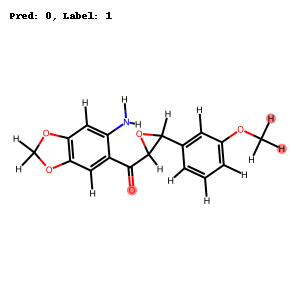

In [101]:
from rdkit.Chem import Draw

img = Draw.MolToImage(mol, highlightAtoms=node.tolist())
from PIL import Image, ImageDraw


pred_max_index = pred.detach().cpu().numpy().argmax()
# 이미지에 텍스트 추가 (예측 결과와 실제 레이블)
draw = ImageDraw.Draw(img)
text = f"Pred: {pred_max_index}, Label: {data.y.item()}"
draw.text((10, 10), text, fill="black")

# save_path = os.path.join(save_dir, f"molecule_3mr.png")
# img.save(save_path)  # 파일 이름을 분자의 인덱스에 따라 지정
display(img)